<a href="https://colab.research.google.com/github/jumbokh/nknu-class/blob/main/notebooks/CNN_2_Kaggle_MRI_2021Fall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 我們要完成的事情
- 到 kaggle 下載 $\Rightarrow$ 可以用 token
- 資料都是在目錄結構，整理成 dataframe

    $\Rightarrow$ 考慮用 data_from_frame

    $\Rightarrow$ 將 str 含與不含 **"mask"** 區隔，放進一個 dataframe 的兩個 columns 裡頭。

    $\Rightarrow$ 如果要只針對 有腫瘤的 mask，可以加一欄標註，當然從 mask matrix 就可以判斷出又沒有腫瘤
- data_generator 設計
- UNET 設計 $\Rightarrow$ 
  - 可以學習設計 resnet block, unet structure
  - keras.models.Model 的寫法
  - 可以研究為什麼要 resnet
- compile and fit
- 熟悉 matplotlib.pyplot, plt.imshow(plt.imread(filename))
- further practice:
  - focal error design



In [1]:
import json
import os
import os.path
from IPython.display import clear_output as clear

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

from skimage import io
# 遇到一個要填寫 matrix 值，結果 plt.imread() array  不給改寫...

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler


#from tensorflow.keras.utils import plot_model
#from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
#import tensorflow.keras.backend as K

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 下載 Kaggle 資料
### 請先登入 Kaggle，在網頁右上角，點選個人帳號圖示，進入設定，然後啟動 “Create New API Token”，將會產生個人 API json 檔同時自動下載到個人電腦。
### 將收到的 json 檔裡頭的 username 與 key 填入下一格中的 api_token 中。



In [9]:
!pip install kaggle

In [13]:
!cp drive/MyDrive/mri_process.py .
from mri_process import kaggle_download, process, show_img_mask, DataGenerator, prediction, tversky, tversky_loss, focal_tversky

cp: cannot stat 'drive/MyDrive/mri_process.py': No such file or directory


In [15]:
api_token = kaggle_download(key = "86e00cd8ed6c732f7c233d9599e581ee")
!cp drive/MyDrive/kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

 
os.chdir('/content')
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
#!kaggle competitions download -c facial-keypoints-detection
!unzip lgg-mri-segmentation.zip 
clear()
del api_token

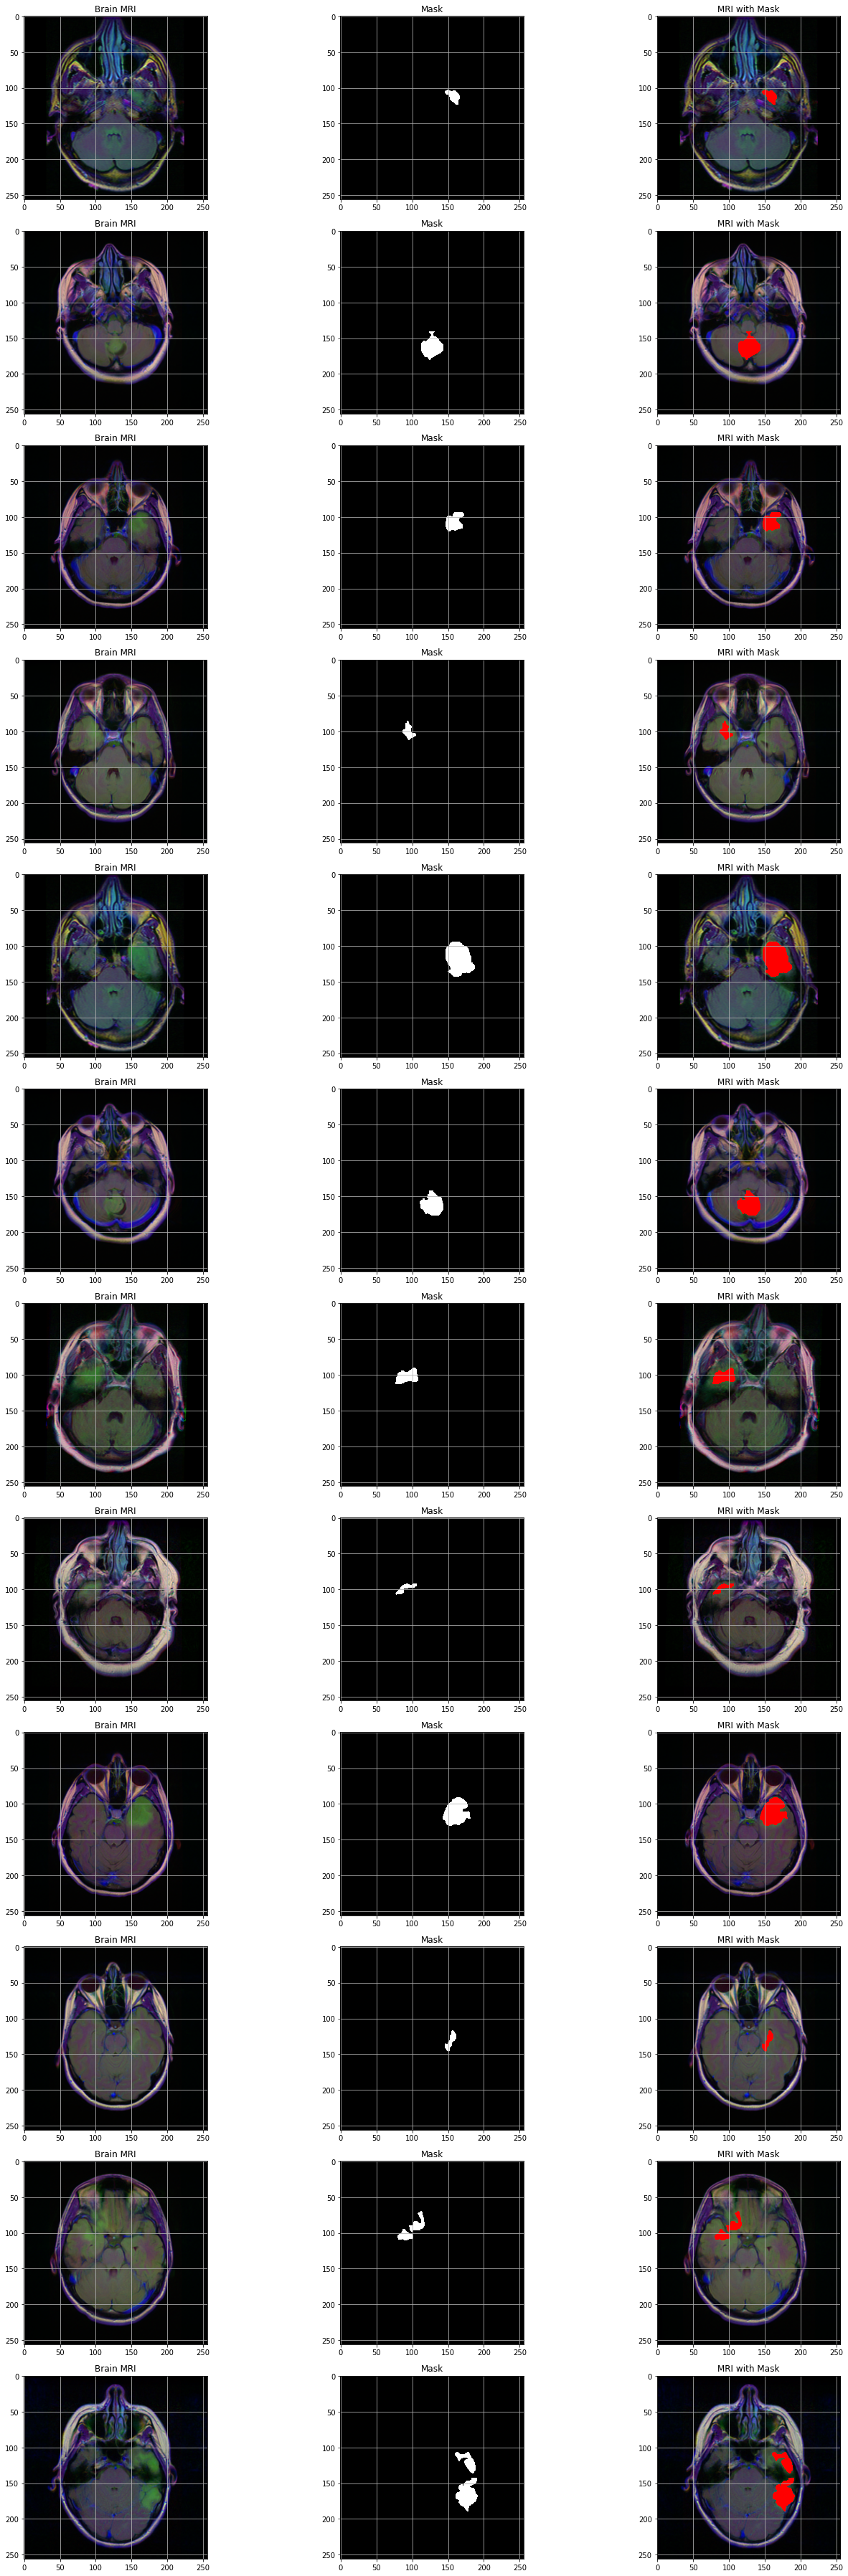

In [16]:
#import mri_process
# file list and dataframe
_, _, Main_Data = process()
#Image_Series, Mask_Series,, Main_Data = mri_process_6.process()
# show image with ground mask
show_img_mask(Main_Data)

## Data Preparation 

In [17]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = Main_Data[Main_Data['Mask_1_0'] == 1] # <== python
brain_df_mask.shape

# split the data into train and test data


X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.IMAGE)
train_mask = list(X_train.MASK)

val_ids = list(X_val.IMAGE)
val_mask= list(X_val.MASK)

# Utilities file contains the code for custom loss function and custom data generator
# create image generators DataGenerator is from utilities.py

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)


In [18]:
X_train.shape #(1167, 3)
X_val.shape # (103, 3)
X_test.shape #(103,3)


(103, 3)

## UNET

In [19]:
def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    UNET Structure
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])
    
    return merge

In [20]:
input_shape = (256,256,3)
X_input = Input(input_shape) #iniating tensor of input shape

# Stage 1
conv_1 = Conv2D(16, 3, activation='relu', padding='same')(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(16, 3, activation='relu', padding='same')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)

# stage 2
conv_2 = Conv2D(32, kernel_size=(3,3), padding='same')(pool_1)
conv_2 = BatchNormalization()(conv_2)
pool_2 = MaxPool2D((2,2))(conv_2)

# Stage 3
conv_3 = Conv2D(64, kernel_size=(3,3), padding='same')(pool_2)
conv_3 = BatchNormalization()(conv_3)
pool_3 = MaxPool2D((2,2))(conv_3)

# Stage 4
conv_4 = Conv2D(128, kernel_size=(3,3), padding='same')(pool_3)
conv_4 = BatchNormalization()(conv_4)
pool_4 = MaxPool2D((2,2))(conv_4)

# Stage 5 (bottle neck)
conv_5 = Conv2D(256, kernel_size=(3,3), padding='same')(pool_4)
conv_5 = BatchNormalization()(conv_5)


# Upsample Stage 1
up_1 = upsample_concat(conv_5, conv_4)
up_1 = Conv2D(128, kernel_size=(3,3), padding='same')(up_1)
up_1 = BatchNormalization()(up_1)

# Upsample Stage 2
up_2 = upsample_concat(up_1, conv_3)
up_2 = Conv2D(64, kernel_size=(3,3), padding='same')(up_2)
up_2 = BatchNormalization()(up_2)

# Upsample Stage 3
up_3 = upsample_concat(up_2, conv_2)
up_3 = Conv2D(32, kernel_size=(3,3), padding='same')(up_3)
up_3 = BatchNormalization()(up_3)

# Upsample Stage 4
up_4 = upsample_concat(up_3, conv_1)
up_4 = Conv2D(16, kernel_size=(3,3), padding='same')(up_4)
up_4 = BatchNormalization()(up_4)


# final output
out = Conv2D(1, (1,1), padding='same', activation='sigmoid')(up_4)

seg_model = Model(X_input, out)
# seg_model.summary()
#plot_model(seg_model)

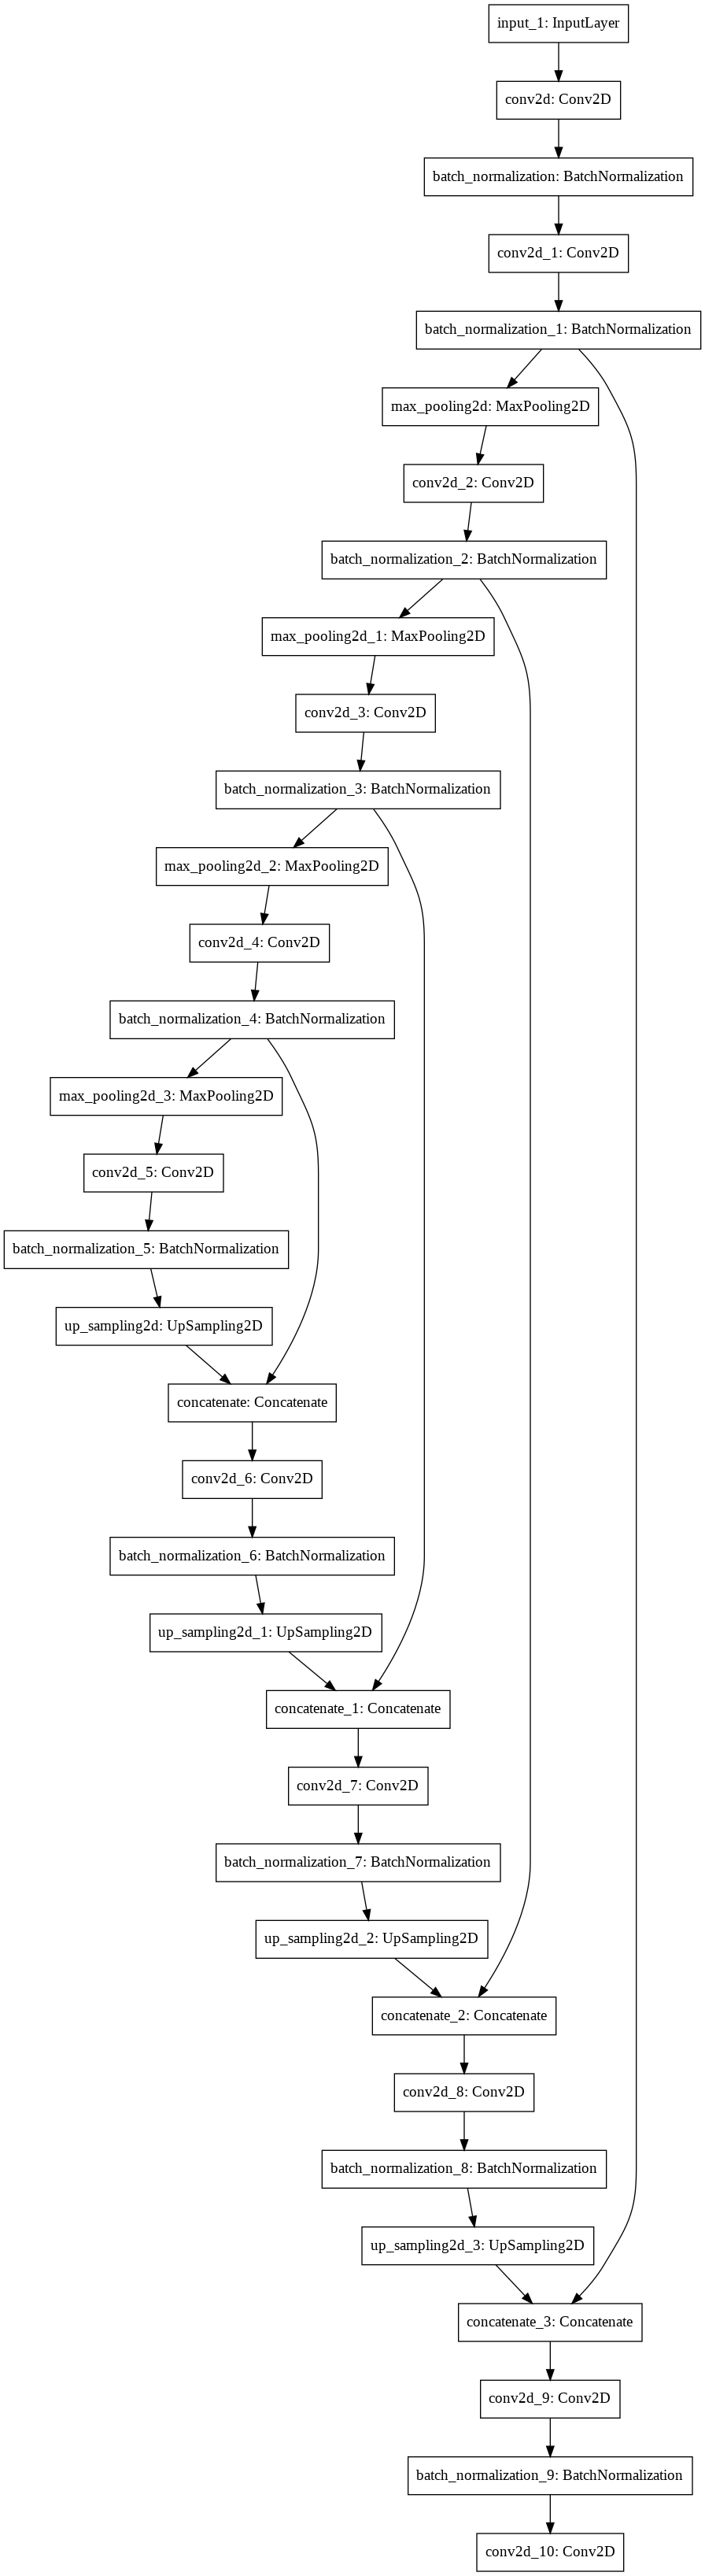

In [21]:
plot_model(seg_model)

In [22]:
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
______________________________________________________________________________________________

In [23]:
from keras.losses import binary_crossentropy
# seg_model.compile(optimizer = 'adam', 
#                   loss = focal_tversky, 
#                   metrics = [tversky]
#                  )

adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
seg_model.compile(optimizer = adam, 
                  loss = binary_crossentropy, #focal_tversky, 
                  metrics = ['accuracy'] #tversky]
                 )
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="UNet-segModel-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [24]:
import keras.backend as K
epoch = 60
shift = 0 
#filename = 'drive/MyDrive/MRI_UNET_bce_' + str(epoch+shift) + '.h5' 
filename = 'drive/MyDrive/MRI_UNET_bce_test_tversky_epoch3' + str(epoch+shift) + '.h5' 

if os.path.exists(filename): 
  #del seg_model
  seg_model = load_model(filename)
  print('file exists!')
else: 
  #history = seg_model.fit(training_generator, epochs = epoch , validation_data = validation_generator) # ,callbacks = [checkpointer, earlystopping])
  history = seg_model.fit(training_generator, 
                          epochs = epoch , 
                          validation_data = validation_generator,
                          callbacks =  [checkpointer, earlystopping, reduce_lr]) # ,callbacks = [checkpointer, earlystopping])

  seg_model.save(filename)
 
 
image_out = [] # test data file path list
tumor_out = [] # is our prediction list: with tumor "1" or no tumor "0"
pred_out = []
label_out = [] # test data ground truth file path list
k = 10
for (i, j) in zip(X_test.IMAGE[:k], X_test.MASK[:k]):
  img = io.imread(i)
  img = img /255.
  #img = np.array(img)
  img = img.reshape(1, 256,256, 3)
  tumor = seg_model.predict(img) #
  if np.argmax(tumor) == 0:
    image_out.append(i)
    tumor_out.append(0)
    pred_out.append('No mask')
    label_out.append(j)
    continue
 
  img = io.imread(i) 
  x = np.empty((1,256,256,3)) 
  img = np.array(img, dtype = np.float64)
 
  img -= img.mean()
  img /= img.std()
  x[0,] = img
  predict = seg_model.predict(x)
    #if the sum of predicted values is equal to 0 then there is no tumour
  if predict.round().astype(int).sum() == 0:
    image_out.append(i)
    tumor_out.append(0)
    pred_out.append('No mask')
    label_out.append(j)
  else:
    #if the sum of pixel values are more than 0, then there is tumour
    image_out.append(i)
    tumor_out.append(1)
    pred_out.append(predict)
    label_out.append(j)

Epoch 1/60
72/72 [==============================] - 54s 255ms/step - loss: 0.2905 - accuracy: 0.9240 - val_loss: 0.1102 - val_accuracy: 0.9713

Epoch 00001: val_loss improved from inf to 0.11021, saving model to UNet-segModel-weights.hdf5
Epoch 2/60
72/72 [==============================] - 18s 250ms/step - loss: 0.0667 - accuracy: 0.9817 - val_loss: 0.0714 - val_accuracy: 0.9745

Epoch 00002: val_loss improved from 0.11021 to 0.07141, saving model to UNet-segModel-weights.hdf5
Epoch 3/60
72/72 [==============================] - 18s 252ms/step - loss: 0.0506 - accuracy: 0.9840 - val_loss: 0.0551 - val_accuracy: 0.9800

Epoch 00003: val_loss improved from 0.07141 to 0.05509, saving model to UNet-segModel-weights.hdf5
Epoch 4/60
72/72 [==============================] - 18s 252ms/step - loss: 0.0463 - accuracy: 0.9844 - val_loss: 0.0491 - val_accuracy: 0.9851

Epoch 00004: val_loss improved from 0.05509 to 0.04909, saving model to UNet-segModel-weights.hdf5
Epoch 5/60
72/72 [==============

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


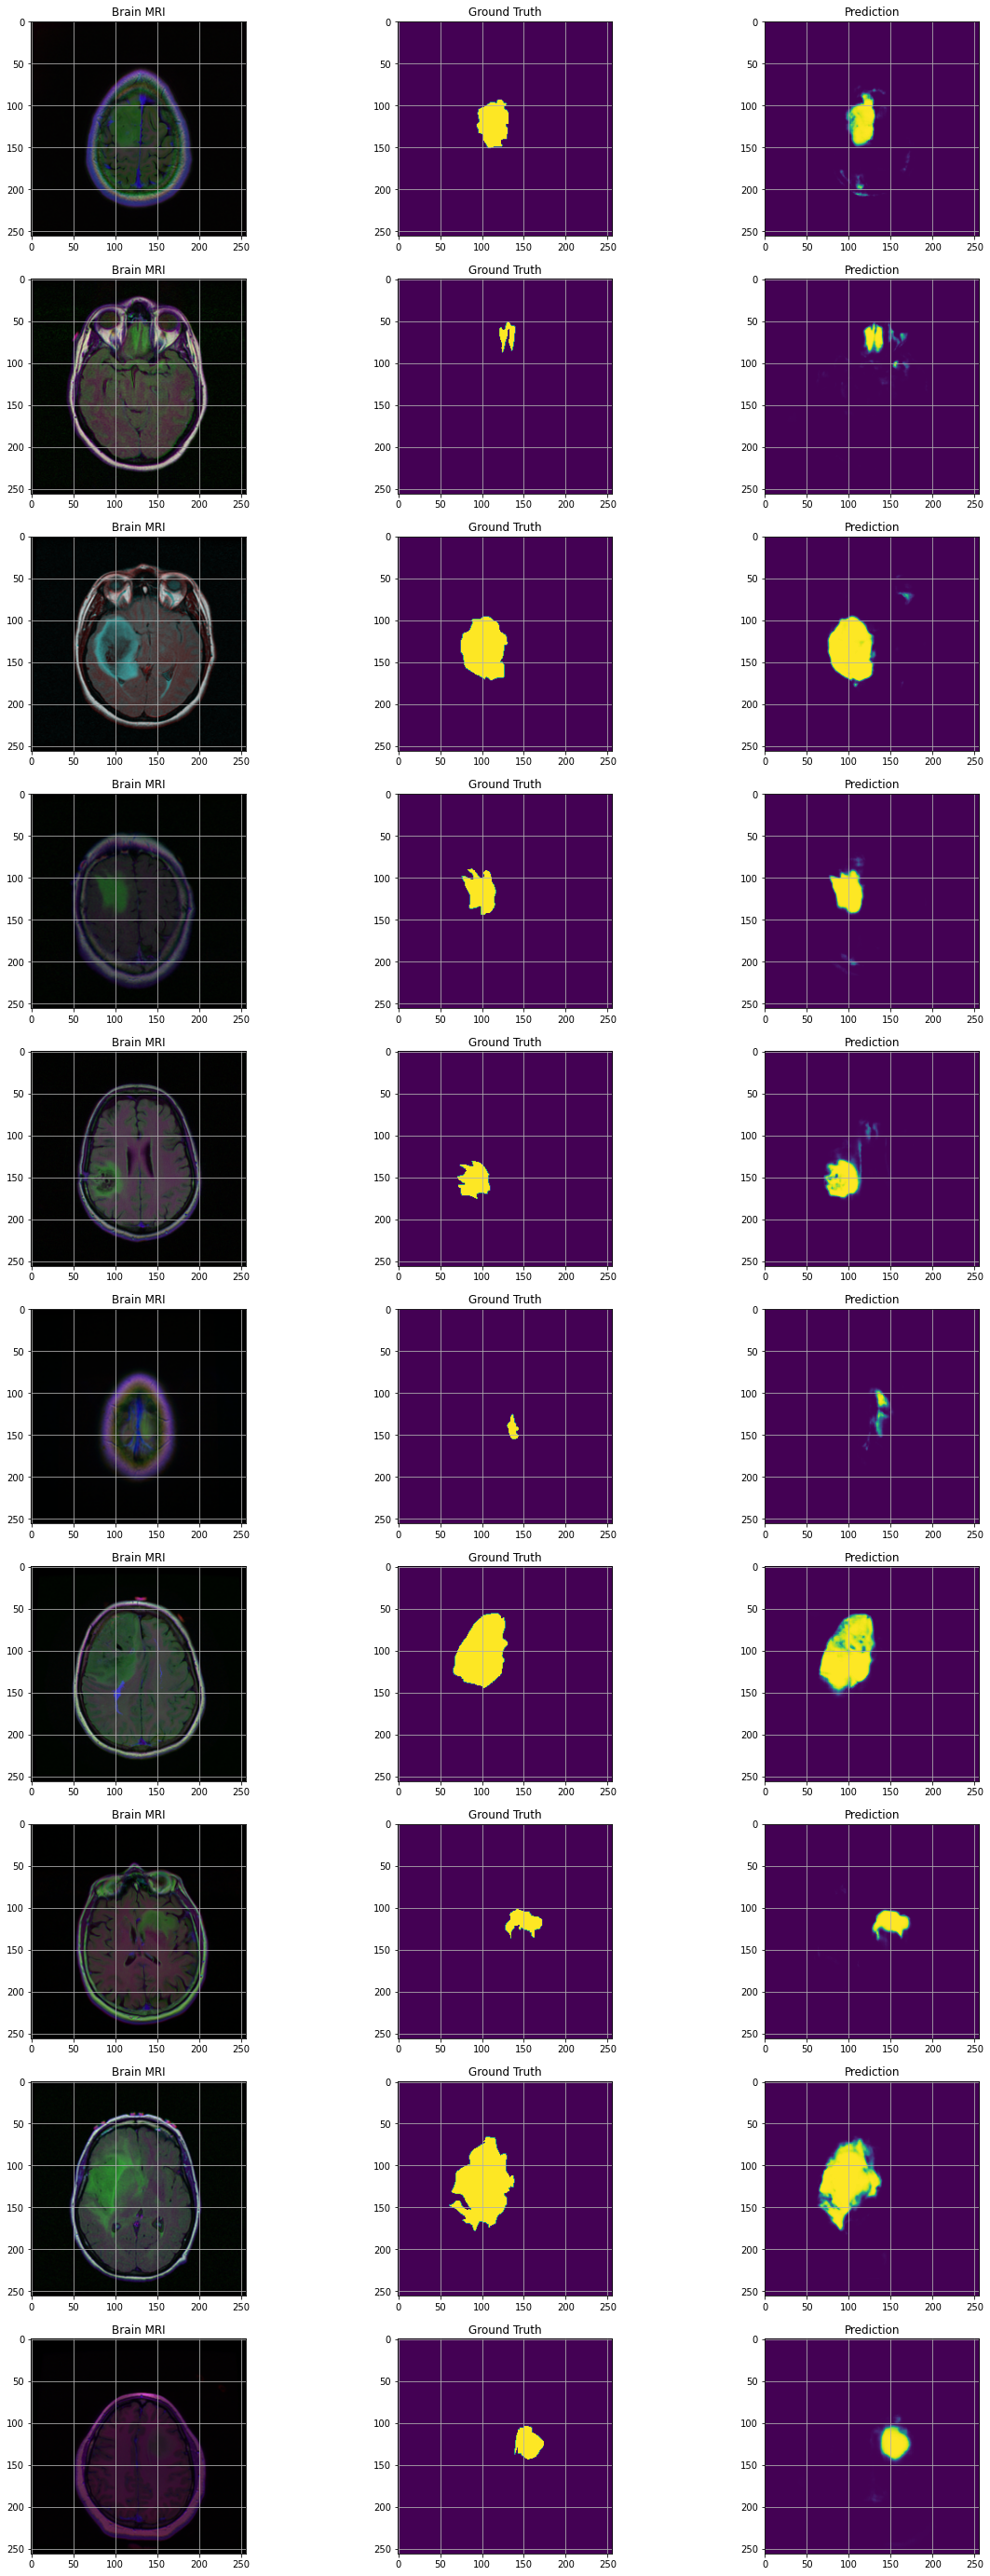

In [25]:
k=10
fig, axs = plt.subplots(10,3, figsize = (20, 50))
for i in range(k):
  if pred_out[i] != 'No mask':
    axs[i][0].title.set_text('Brain MRI')
    axs[i][0].imshow(plt.imread(image_out[i]))
    axs[i][0].grid()
  
    axs[i][1].title.set_text('Ground Truth')
    axs[i][1].imshow(plt.imread(label_out[i]))
    axs[i][1].grid()
  
    axs[i][2].title.set_text('Prediction')
    axs[i][2].imshow(pred_out[i].reshape(256,256))
    axs[i][2].grid()

In [26]:
p = plt.imread(label_out[0])
type(p)
p

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [27]:
X_test.MASK[0:1]

2785    lgg-mri-segmentation/kaggle_3m/TCGA_HT_7605_19...
Name: MASK, dtype: object

In [28]:
image_out = []
tumor_out = []
pred_out = []
label_out = []
k = 10
for (i, j) in zip(X_test.IMAGE[:k], X_test.MASK[:k]):
  img = io.imread(i)
  img = img /255.
  #img = np.array(img)
  img = img.reshape(1, 256,256, 3)
  tumor = seg_model.predict(img)
  if np.argmax(tumor) == 0:
    image_out.append(i)
    tumor_out.append(0)
    pred_out.append('No mask')
    label_out.append(j)
    continue
 
  img = io.imread(i) 
  x = np.empty((1,256,256,3)) 
  img = np.array(img, dtype = np.float64)
 
  img -= img.mean()
  img /= img.std()
  x[0,] = img
  predict = seg_model.predict(x)
  predict[predict >0.5] = 1.  # <== modified here
  predict[predict <0.5] = 0.  # <== modified here
    #if the sum of predicted values is equal to 0 then there is no tumour
  if predict.round().astype(int).sum() == 0:
    image_out.append(i)
    tumor_out.append(0)
    pred_out.append('No mask')
    label_out.append(j)
  else:
    #if the sum of pixel values are more than 0, then there is tumour
    image_out.append(i)
    tumor_out.append(1)
    pred_out.append(predict)
    label_out.append(j)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


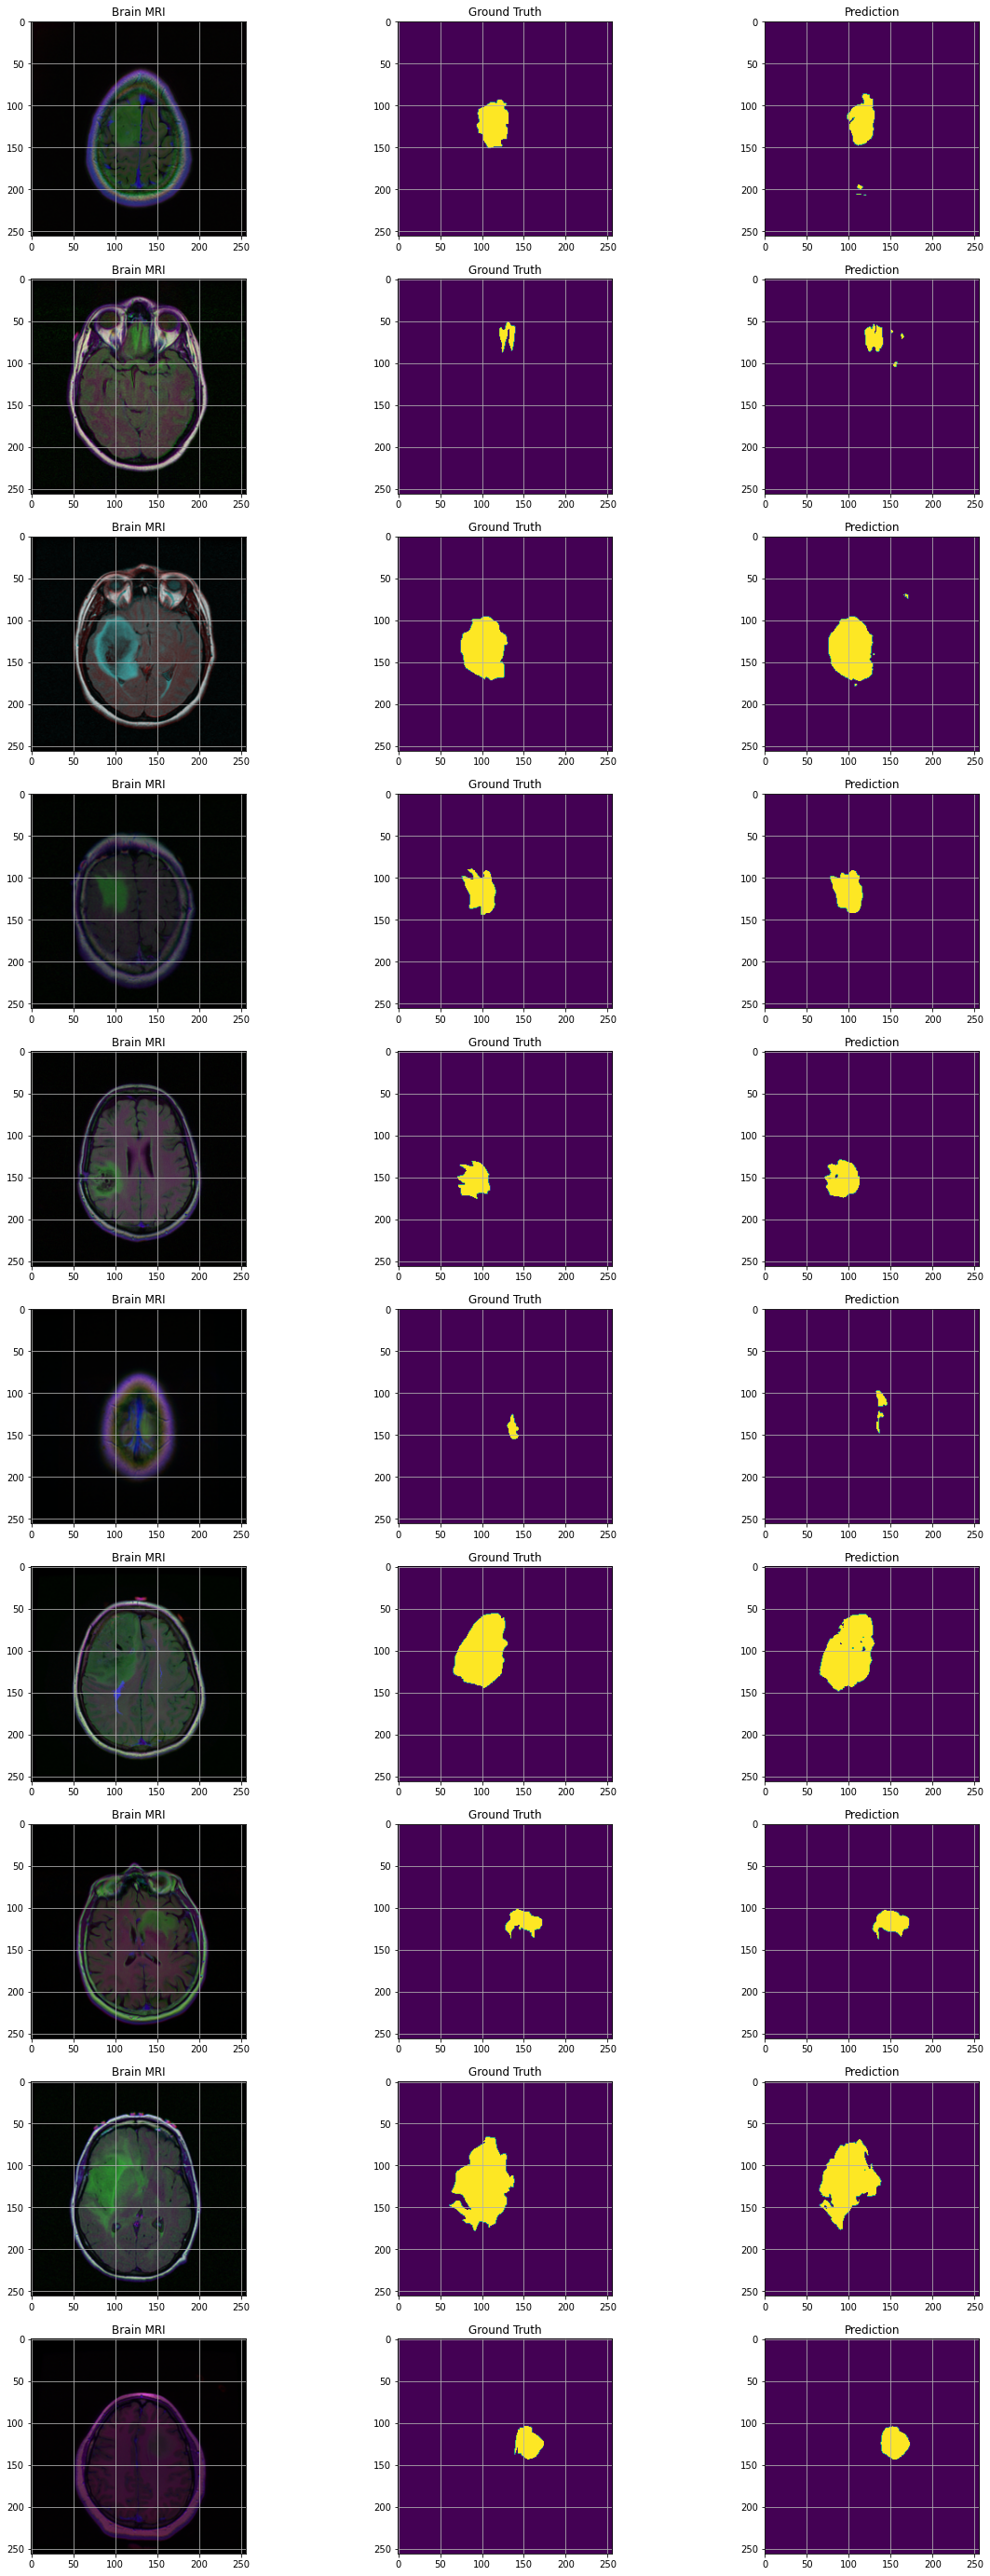

In [29]:
# epoch = 1
k=10
fig, axs = plt.subplots(10,3, figsize = (20, 50))
for i in range(k):
  if pred_out[i] != 'No mask':
    axs[i][0].title.set_text('Brain MRI')
    axs[i][0].imshow(plt.imread(image_out[i]))
    axs[i][0].grid()
  
    axs[i][1].title.set_text('Ground Truth')
    axs[i][1].imshow(plt.imread(label_out[i]))
    axs[i][1].grid()
  
    axs[i][2].title.set_text('Prediction')
    axs[i][2].imshow(pred_out[i].reshape(256,256))
    axs[i][2].grid()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


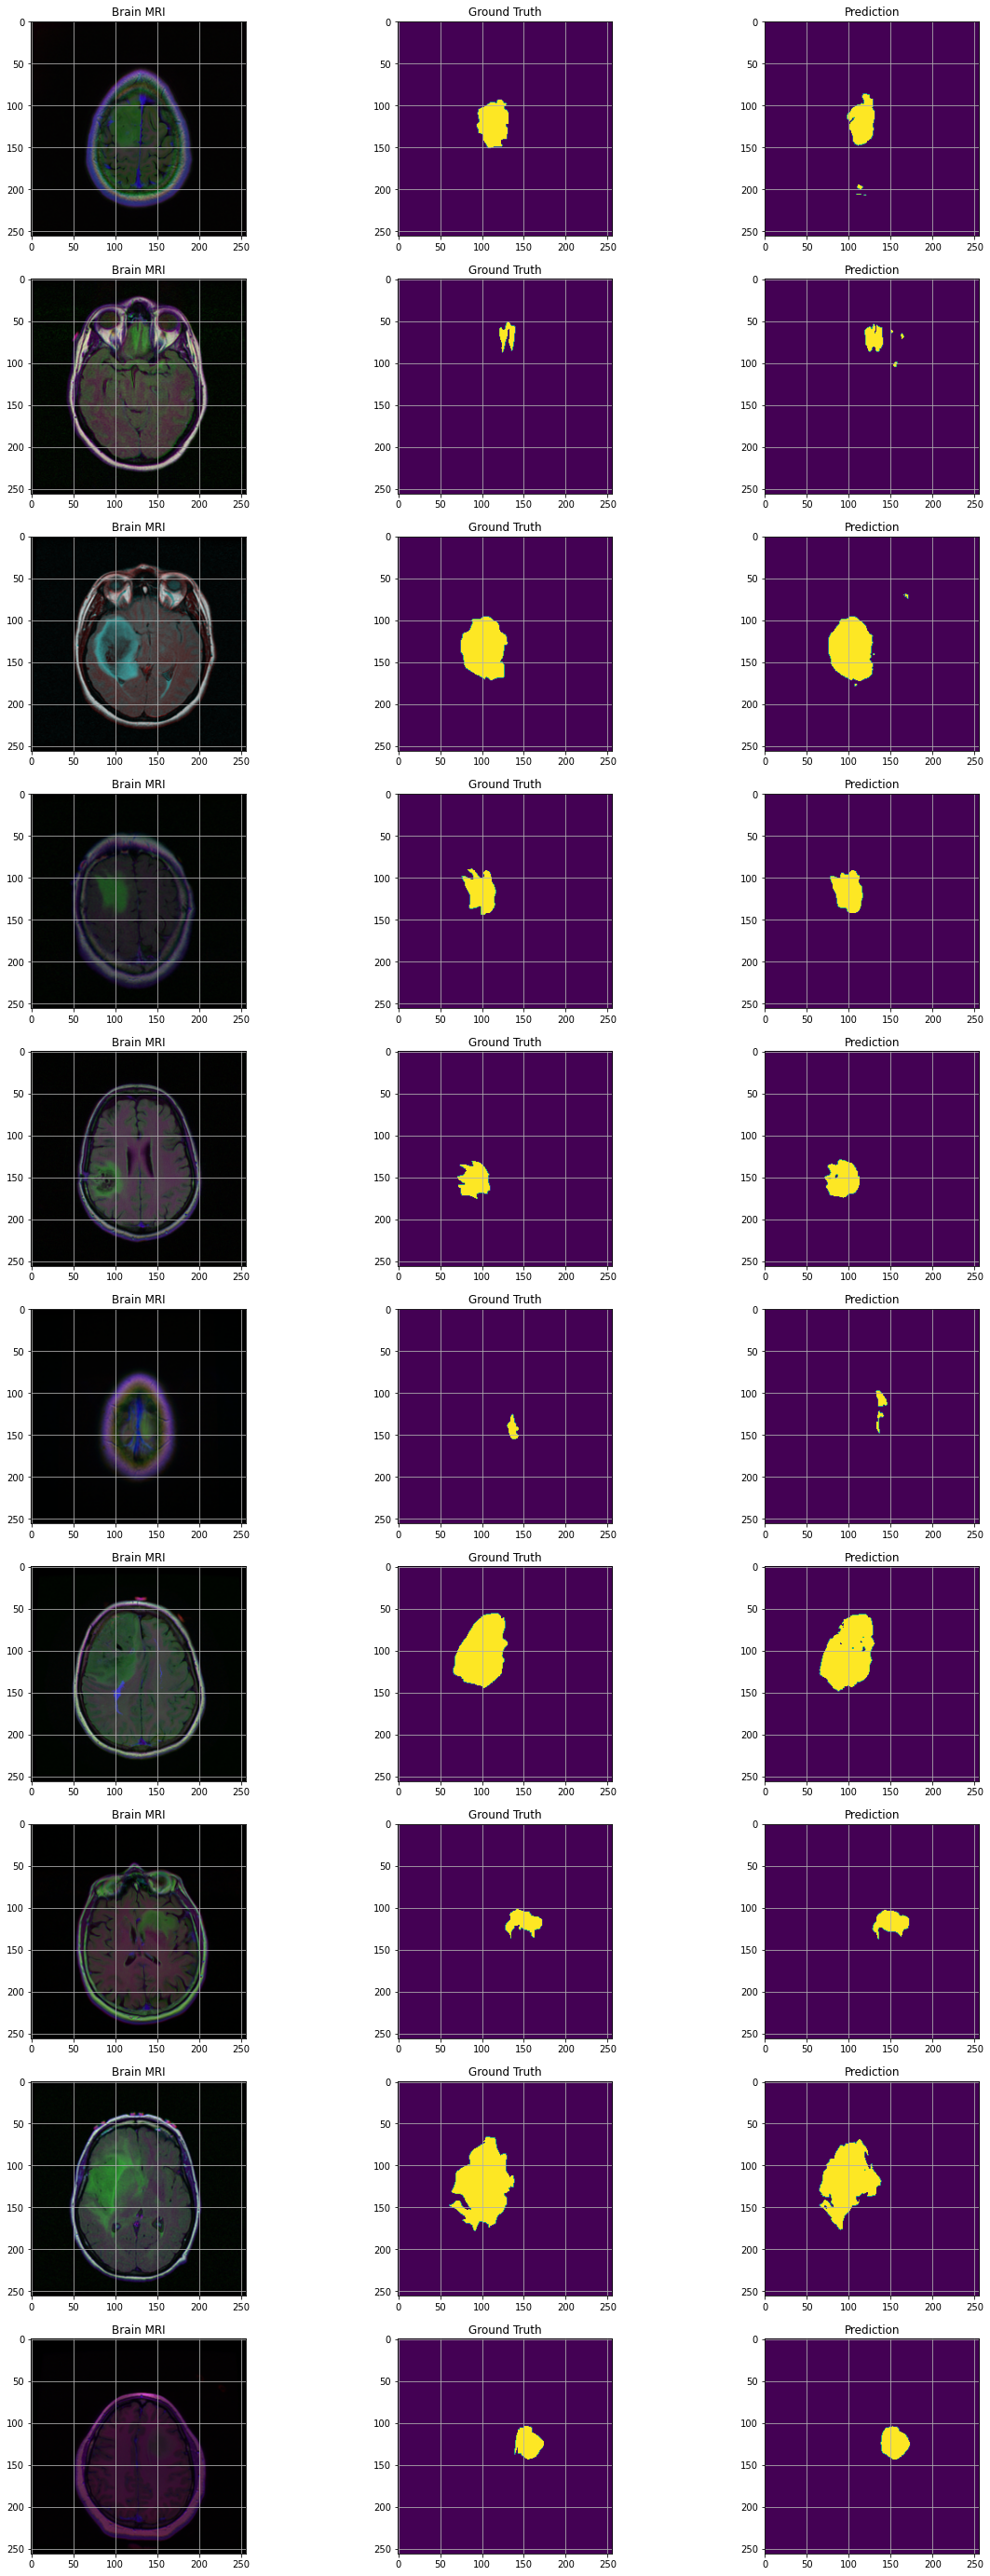

In [30]:
image_out = []
tumor_out = []
pred_out = []
label_out = []
k = 10
for (i, j) in zip(X_test.IMAGE[:k], X_test.MASK[:k]):
  img = io.imread(i)
  img = img /255.
  #img = np.array(img)
  img = img.reshape(1, 256,256, 3)
  tumor = seg_model.predict(img)
  if np.argmax(tumor) == 0:
    image_out.append(i)
    tumor_out.append(0)
    pred_out.append('No mask')
    label_out.append(j)
    continue
 
  img = io.imread(i) 
  x = np.empty((1,256,256,3)) 
  img = np.array(img, dtype = np.float64)
 
  img -= img.mean()
  img /= img.std()
  x[0,] = img
  predict = seg_model.predict(x)
  predict[predict >0.5] = 1.  # <== modified here
  predict[predict <0.5] = 0.  # <== modified here
    #if the sum of predicted values is equal to 0 then there is no tumour
  if predict.round().astype(int).sum() == 0:
    image_out.append(i)
    tumor_out.append(0)
    pred_out.append('No mask')
    label_out.append(j)
  else:
    #if the sum of pixel values are more than 0, then there is tumour
    image_out.append(i)
    tumor_out.append(1)
    pred_out.append(predict)
    label_out.append(j)

# epoch = 1
k=10
fig, axs = plt.subplots(10,3, figsize = (20, 50))
for i in range(k):
  if pred_out[i] != 'No mask':
    axs[i][0].title.set_text('Brain MRI')
    axs[i][0].imshow(plt.imread(image_out[i]))
    axs[i][0].grid()
  
    axs[i][1].title.set_text('Ground Truth')
    axs[i][1].imshow(plt.imread(label_out[i]))
    axs[i][1].grid()
  
    axs[i][2].title.set_text('Prediction')
    axs[i][2].imshow(pred_out[i].reshape(256,256))
    axs[i][2].grid()